In [1]:
import cbpro
import pickle
import pandas as pd
import numpy as np

In [2]:
#load data
candStart = '2021-01-22T14:40:00'
candEnd = '2021-01-22T18:00:00'
filePath = './data/candles_' + candStart + '_' + candEnd

infile = open(filePath, 'rb')
dL = pickle.load(infile)
infile.close()
candles = pd.DataFrame(dL, columns=['time', 'low', 'high', 'open', 'close', 'volume'])
candles.head

<bound method NDFrame.head of            time       low      high      open     close     volume
0    1611338400  32363.47  32425.55  32371.13  32407.77   9.706368
1    1611338340  32349.99  32393.76  32350.00  32374.19  12.865255
2    1611338280  32315.36  32350.00  32345.23  32350.00  17.952454
3    1611338220  32311.94  32350.00  32332.03  32349.82  12.302965
4    1611338160  32298.83  32343.67  32342.24  32333.58   6.455700
..          ...       ...       ...       ...       ...        ...
196  1611326640  32293.14  32350.00  32326.55  32346.00  38.276682
197  1611326580  32307.85  32335.28  32333.44  32324.16  15.005228
198  1611326520  32304.76  32350.00  32304.77  32330.09  19.305429
199  1611326460  32273.10  32325.21  32282.29  32304.78  12.234866
200  1611326400  32258.56  32350.00  32349.99  32274.99  26.518412

[201 rows x 6 columns]>

In [3]:
startPrice = candles['close'][0]
print(startPrice)

32407.77


In [50]:
#PREDICTION UPDATE
#constants:

#X Systen state 
# x = [p, dp] x is state vector, p is price, dp is change in price or velocity of price
startVel = 0
startprice = candles['close'][0]
X = np.array([startPrice, startVel])

#Q system uncertainty
uncerPos = 10
uncerVel = .1 #change per second
Q = np.array([[uncerPos, 0],[0, uncerVel]])

#P Initial Cov 
varVel = 1
varPos = 1
P = [[varPos, 0], [0, varVel]]

#F transformation matrix from time time t-1 to t
delT = 60 #time in seconds
F = np.array([[1, delT],[0, 1]])

def predict(X, F, P, Q):
    #prediction state update
    X1 = np.matmul(F, X)
    
    #P1 = F*P*F' + Q
    P1 = np.matmul(np.matmul(F, P), np.transpose(F)) + Q
    return X1, P1

In [11]:
#test update prediction steps
for _ in range(3):
    print('\n\nX: ' + str(X) + '\nP:' + str(P) + '\nQ:' + str(Q) + '\nF:' + str(F))

    X, P = predict(X, F, P, Q)

print('\n\nX: ' + str(X) + '\nP:' + str(P) + '\nQ:' + str(Q) + '\nF:' + str(F))



X: [32407.77     0.  ]
P:[[1, 0], [0, 1]]
Q:[[10.   0. ]
 [ 0.   0.1]]
F:[[ 1 60]
 [ 0  1]]


X: [32407.77     0.  ]
P:[[3.611e+03 6.000e+01]
 [6.000e+01 1.100e+00]]
Q:[[10.   0. ]
 [ 0.   0.1]]
F:[[ 1 60]
 [ 0  1]]


X: [32407.77     0.  ]
P:[[1.4781e+04 1.2600e+02]
 [1.2600e+02 1.2000e+00]]
Q:[[10.   0. ]
 [ 0.   0.1]]
F:[[ 1 60]
 [ 0  1]]


X: [32407.77     0.  ]
P:[[3.4231e+04 1.9800e+02]
 [1.9800e+02 1.3000e+00]]
Q:[[10.   0. ]
 [ 0.   0.1]]
F:[[ 1 60]
 [ 0  1]]


In [23]:
#Update step
#measurement uncertainty
uncerPos = 10
uncerVel = .1 #change per second
R = np.array([[uncerPos, 0],[0, uncerVel]])

#observation
obs = np.array([candles['close'][1], (candles['close'][0] - candles['close'][1])])

#H = np.array([1, 0])

def update(obs, X, P, R):
    KalGain = np.matmul(P, np.linalg.inv(P + R))
    XU = X + np.matmul(KalGain, (obs - X))
    PU = P + np.matmul(KalGain, P)
    
    return XU, PU

In [ ]:
"""
    #Test Update
    print, xP
    print('obMean: ' + str(obMean))
    print('XU: ' + str(XU) + ' PU: ' + str(PU))
"""

In [90]:
#measurement uncertainty
uncerPos = 100
uncerVel = 10 #change per second
R = np.array([[uncerPos, 0],[0, uncerVel]])

# x = [p, dp] x is state vector, p is price, dp is change in price or velocity of price
startVel = 0
startprice = candles['close'][0]
X = np.array([startPrice, startVel])

#Q system uncertainty
uncerPos = 10
uncerVel = 1 #change per second
Q = np.array([[uncerPos, 0],[0, uncerVel]])

#P Initial Cov 
varVel = 1
varPos = 1
P = [[varPos, 0], [0, varVel]]

#F transformation matrix from time time t-1 to t
delT = 1 #time in seconds
F = np.array([[1, delT],[0, 1]])


pred = [None]
for num in range(len(candles.index) - 1):
    X, P = predict(X, F, P, Q)
    #print('X: ' + str(X))
    print(num)
    print(X)
    pred.append(X[0])
   # print('P: ' + str(P))
    
    #observation
    obs = np.array([candles['close'][num + 1], (candles['close'][num] - candles['close'][num + 1])])
    X, P = update(obs, X, P, R) 

candles["pred"] = pred
    
    
    

0
[32407.77     0.  ]
1
[3.24120206e+04 5.32579300e+00]
2
[3.24113682e+04 8.62708094e+00]
3
[3.23899933e+04 3.48433308e+00]
4
[3.23737608e+04 5.04717175e+00]
5
[ 3.23397748e+04 -3.19461191e+00]
6
[3.23532483e+04 1.05340649e+01]
7
[3.23171825e+04 1.13543321e+01]
8
[ 3.22883731e+04 -6.77477605e-01]
9
[3.23022786e+04 2.15310292e+01]
10
[ 3.22585777e+04 -1.02579799e+01]
11
[3.228639e+04 1.833315e+01]
12
[32254.70011137    37.21521524]
13
[32209.3596925    54.9871142]
14
[3.21510871e+04 2.09525033e+01]
15
[32134.58928188   -37.80889075]
16
[ 3.21753291e+04 -8.31779084e+00]
17
[ 3.21829269e+04 -1.61550348e+01]
18
[ 3.21993400e+04 -2.77310711e+01]
19
[3.22270679e+04 4.39737428e+00]
20
[ 3.22225614e+04 -1.16861721e+01]
21
[32234.34643228   -47.46109147]
22
[ 3.22818500e+04 -3.18385716e+01]
23
[ 3.23136675e+04 -3.90238230e+00]
24
[3.23175531e+04 2.11480712e+01]
25
[32296.40910538   -38.93471856]
26
[32335.35082615   -45.588648  ]
27
[32380.94116467   -66.73813887]
28
[32447.67712706    47.67550

<bound method NDFrame.head of           time       low      high      open     close     volume meanPred  \
10  1611337800  32252.79  32297.00  32255.94  32287.48   8.147155            
11  1611337740  32200.21  32272.99  32210.57  32255.94  19.584618            
12  1611337680  32137.56  32210.61  32144.00  32210.57  15.991981            
13  1611337620  32129.91  32155.01  32132.97  32150.00  10.949312            
14  1611337560  32126.00  32245.94  32175.81  32132.95  54.434512            
15  1611337500  32138.74  32194.98  32185.39  32175.81  25.995974            
16  1611337440  32166.99  32221.84  32199.24  32182.82  32.488762            
17  1611337380  32185.00  32268.18  32233.47  32199.24  28.528371            
18  1611337320  32204.23  32235.91  32222.04  32227.20  15.844549            
19  1611337260  32210.01  32245.27  32237.67  32222.52  18.252650            

            pred  
10  32302.278599  
11  32258.577686  
12  32286.390050  
13  32254.700111  
14  32209.359693

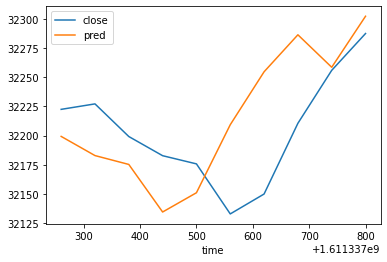

In [92]:

candles[10:20].plot(x = 'time', y = ['close','pred'])
candles[10:20].head